In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy as scp
from scipy import optimize
from scipy import special
from scipy import stats
from scipy.stats import invgauss, pareto
from itertools import product
import xarray 
import warnings
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import os
import seaborn as sns
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from scipy.interpolate import interp1d
import simpy
import random as rand
import statistics as stat
from PIL import Image
from scipy.interpolate import griddata
from msmbuilder.msm.core import _solve_msm_eigensystem

fsize = 12.5
tsize = 12
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
# plt.style.use('default')
plt.style.use('seaborn-colorblind')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
plt.rc("savefig", dpi=600)
plt.rcParams['axes.titley'] = 1.0
titles = ["(a)","(b)","(c)","(d)","(e)","(f)"]

warnings.filterwarnings('ignore')

imprting


In [194]:
class UGME(object):
    def __init__(self, tsteps=1, rd=1, dt=1.0):
        self.dt = dt
        self.tsteps = tsteps
        self.rd = rd
        self.exact = np.zeros((tsteps, rd, rd))
        self.lag_time = np.zeros(tsteps)
        self.tau_r = 0
        self.tau_R = 0
        self.cutoff_list = np.zeros(tsteps)
        self.U_matrix = np.zeros(tsteps)
        self.rmses = np.zeros(tsteps)
        self.__row_norm = False
        self.__col_norm = False
        self.__get_data = False
        self.__get_dTPM_dt = False


    def GetData(self, input_data):
        # load data and find out which normalization
        temp = np.load(input_data, allow_pickle=True) #[0] may need to remove this
        temp = np.einsum("ijk->kji", temp)
        #print(temp.shape)
        self.rd, self.tsteps = temp[0].shape

        # add identity matrix
        self.tsteps += 1
        self.exact = np.zeros([self.rd, self.rd, self.tsteps])
        self.exact[:, :, 0] = np.eye(self.rd)
        self.exact[:, :, 1:] = np.copy(temp)
        
        return self.exact

    def which_normalization(self):
        """
        Check if a time-dependent matrix is row or column normalized across time steps.

        Parameters:
        -----------
        TPM : numpy.ndarray
            A time-dependent matrix with shape [time_steps, rows, columns].

        Returns:
        --------
        int
            Returns 0 if the matrix is column-normalized across time steps,
            Returns 1 if the matrix is not column-normalized across time steps.
            Prints the normalization status for rows and columns across time steps.

        This function calculates row and column sums across the specified axes for each time step 
        and checks if the sums are approximately equal to 1, indicating row or column normalization.
        """
        # Normalize along rows and columns
        row_sums = np.sum(self.exact, axis=1)  # Sum across columns for each time step
        col_sums = np.sum(self.exact, axis=0)  # Sum across rows for each time step

        # Check if rows sum up to 1 for each time step (row normalization)
        row_normalized = np.all(np.isclose(row_sums, 1.0))

        # Check if columns sum up to 1 for each time step (column normalization)
        col_normalized = np.all(np.isclose(col_sums, 1.0))

        if row_normalized:
            print("The matrix is row-normalized at all times.")
            

        if col_normalized:
            print("The matrix is column-normalized at all times.")
            return 0

    def Get_U(self):
        self.U_matrix = np.zeros_like(self.exact)

        # initial value
        self.U_matrix[:, :, 0] = np.copy(self.exact[:, :, 0])

        # get the inverse
        for k in range(1, self.tsteps):
                    self.U_matrix[:, :, k] = np.dot(self.exact[:, :, k],
                                                    np.linalg.inv(self.exact[:, :, k-1]))
    
        return self.U_matrix

    def GetAve(self, t_r, t_R):
        return np.average(self.U_matrix[:, :, t_r:t_R], axis=-1)

    def GetCfromU(self, U_inf, tau_R, long_tsteps=1):
        upper_limit = int(np.max((self.tsteps, long_tsteps)))
        # Ct = np.zeros_like(self.exact)
        Ct = np.zeros((self.rd, self.rd, upper_limit))
        Ct[:, :, 0] = np.eye(self.rd)
        for k in range(1, tau_R): Ct[:, :, k] = np.copy(self.exact[:, :, k])
        for k in range(tau_R, upper_limit): Ct[:, :, k] = U_inf @ Ct[:, :, k-1]
        return Ct

    def rmse(self, matrix):
        total = 0.0
        for k in range(self.tsteps):
            difference  = self.exact[:, :, k] - matrix[:, :, k]
            difference_squared = difference**2
            total += np.sum(difference_squared)
        total = (total / (self.tsteps * self.rd**2))**0.5
        return total

    def rmse_only_tau_R(self, cutoff_list, save=1):
        """
        This does not use the onset of averaging parameter
        only uses the final cutoff times tR
        """
        if save:
            self.rmses = []
            self.cutoff_list = cutoff_list
        for tR in cutoff_list:
            tR = int(tR)
            U_inf = self.U_matrix[:, :, int(tR)]
            prediction = self.GetCfromU(U_inf, tR)
            self.rmses.append(self.rmse(prediction))
        return self.rmses
        

    def rmse_with_tr(self, tr_list):
        """
        This DOES use the onset of averaging parameter, tr
        """
        tr_rmses_list = []

        for tr in tr_list:
            tr = int(tr)
            new_cutoff_list = self.cutoff_list[self.cutoff_list > tr]

            tR_rmses = []
            for tR in new_cutoff_list:
                tR = int(tR)
                U_inf = self.GetAve(tr, tR)
                prediction = self.GetCfromU(U_inf, tR)
                tR_rmses.append(self.rmse(prediction))
            tr_rmses_list.append(np.array(tR_rmses))

        return tr_rmses_list

In this notebook I summerize all work done so far in the project and show current results.

# 4-states model system

I start with a model system of a diffusing particle in a 3D potential. The XY and XZ integrated FES are presented below. 

I ran ten, one-microsecond long unbiased trajectories initiated at $(\{-5,5,5\} + \boldsymbol{\eta})$ angstrom, where $\boldsymbol{\eta}$ is a vector of random numbers uniformly sampled between -1 to 1. I then divided each trajectory to ten segments of equal length, obtaining overall 100, 100-ns long trajectories (my computer actually broke near the end of the simulations, so ten of the trajectories are a few nanoseconds shorter). The simulations can be reproduced using the openMM_4States.py script in the reweightingtools directory. They were conducted in openMM using Langevin dynamics, with a time step of 1 femtosecond. The position was saved every 50 fs. In the analysis below, I used data points in intervals of 0.1 ps.

The unbiased trajectories were used to find 100 microstates, using the MiniBatchKMeans clustering function of msmbuilder. An MSM with a time lag of 20 ps was built and used to find 4 macrostates through the PCCA+ algorithm. Below I show the microstates centers, colored by their associated macrostates.

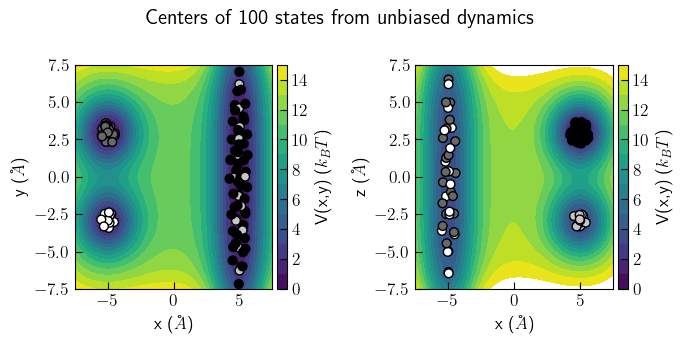

In [181]:
xs = []
ys = []
zs = []
Vs = []
for x in np.linspace(-7.5,7.5,51):
    for y in np.linspace(-7.5,7.5,51):
        for z in np.linspace(-7.5,7.5,51):
            xs.append(x)
            ys.append(y)
            zs.append(z)
            Vs.append(0.001*x**4-0.05*x**2+0.001*y**4+0.001*z**4 - 12.5*np.exp(-0.2*(z-3)**2-0.2*(x-5)**2)- 
                      10*np.exp(-0.2*(z+3)**2-0.2*(x-5)**2)- 11*np.exp(-0.2*(y-3)**2-0.2*(x+5)**2)- 
                      10*np.exp(-0.2*(y+3)**2-0.2*(x+5)**2))
surface = pd.DataFrame({"x":xs,"y":ys,"z":zs,"V":Vs})
surface.V -= surface.V.min()
# surface.V = surface.V / 1.25
surface["H"] = np.exp(-surface.V)

surfaceXY = surface.groupby(["x","y"]).sum("H").reset_index()
surfaceXY.H = surfaceXY.H/surfaceXY.H.sum()
surfaceXY.V = -np.log(surfaceXY.H)
surfaceXY.V -= surfaceXY.V.min()

surfaceXZ = surface.groupby(["x","z"]).sum("H").reset_index()
surfaceXZ.H = surfaceXZ.H/surfaceXZ.H.sum()
surfaceXZ.V = -np.log(surfaceXZ.H)
surfaceXZ.V -= surfaceXZ.V.min()

states_centers = np.load("model_system/states_centers.npy")
states_mapping = np.load("model_system/states_mapping.npy")

fig, axs = plt.subplots(1,2,figsize=(7,3.5))

im = axs[0].tricontourf(surfaceXY.x,surfaceXY.y,surfaceXY.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[0].scatter(states_centers[:, 0],
                    states_centers[:, 1],
                    s=40, c = states_mapping, edgecolor="black", cmap='Greys')
axs[0].set_xlabel(r"x ($\AA$)")
axs[0].set_ylabel(r"y ($\AA$)")

im = axs[1].tricontourf(surfaceXZ.x,surfaceXZ.z,surfaceXZ.V,levels=np.linspace(0,15,16))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[1].scatter(states_centers[:, 0],
           states_centers[:, 2],
           s=40, c = states_mapping ,edgecolor="black", cmap='Greys')

for ax in axs:
    ax.set_xlim(*ax.get_xlim())
    ax.set_ylim(*ax.get_ylim())

axs[1].set_xlabel(r"x ($\AA$)")
axs[1].set_ylabel(r"z ($\AA$)")

fig.suptitle("Centers of 100 states from unbiased dynamics")
fig.tight_layout()

I calculated the transition matrix at times up to 1 ns directly from the count matrix, without enforcing detailed balance, and use here this data as "ground truth". I performed bootstrapping with 100 batches to estimate the error. Below are the three slowest implied timescales (ITS) for a standard, four-states MSM.

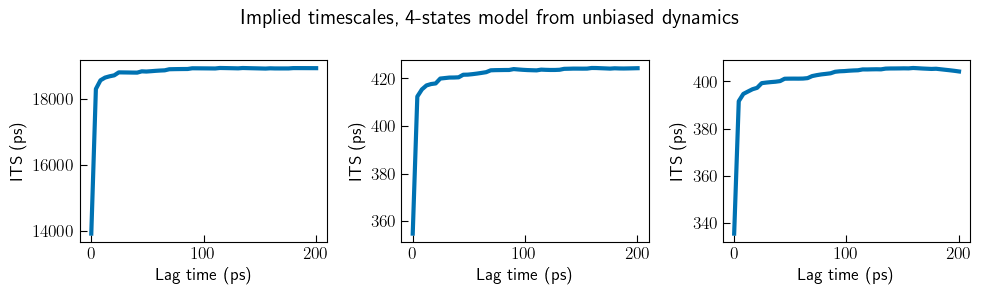

In [198]:
TPM = np.load("model_system/unbiased_TPM.npy")
TPM_error = np.load("model_system/unbiased_TPM_error.npy")
lagtimes = np.linspace(1, 2001, 50)
dt = 0.1 # ps
ITS = []
for lagtime in lagtimes:
    u, lv, rv = _solve_msm_eigensystem(TPM[int(lagtime)], 4)
    with np.errstate(invalid='ignore', divide='ignore'):
        ITS.append(- lagtime / np.log(u[1:]))
ITS = np.array(ITS)
fig, axs = plt.subplots(1, 3, figsize = (10, 3))
for i in range(3):
    axs[i].plot(lagtimes * dt, ITS[:,i] * dt, lw=3)
    axs[i].set_xlabel("Lag time (ps)")
    axs[i].set_ylabel("ITS (ps)")
    
fig.suptitle("Implied timescales, 4-states model from unbiased dynamics")
fig.tight_layout()

I find timescale $\tau_R$ for the U-GME by plotting the root mean square error (RMSE):

Text(0, 0.5, 'RMSE')

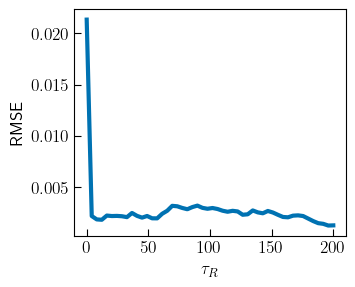

In [199]:
ugme_data = UGME(dt=dt)
ugme_data.exact = np.einsum("ijk->jki", TPM)
ugme_data.rd = 4
ugme_data.tsteps = 10000
U_matrix = ugme_data.Get_U()
rmses = ugme_data.rmse_only_tau_R(lagtimes)

fig, ax = plt.subplots(figsize = (3.5, 3))

ax.plot(lagtimes * dt, rmses, lw=3)
ax.set_xlabel(r"$\tau_R$")
ax.set_ylabel("RMSE")

Here are the dynamics for a standard MSM with timelag of 100 ps and a U_GME with $\tau_R$ = 10 ps. The states index 1, 2, 3, and 4 match the white, light grey, dark grey and black states above, respectedly.

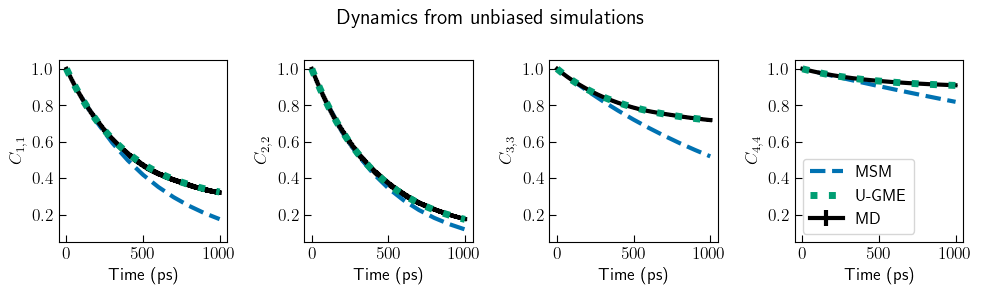

In [202]:
# set the lifetime of the U matrix
tau_R = 100

U_inf = U_matrix[:, :, tau_R]

# get TPMs with this assumption
Ct = ugme_data.GetCfromU(U_inf, tau_R)

fig, axs = plt.subplots(1,4,figsize=(10,3))

skip = 10
for i in range(4):

    # The MD dynamics
    axs[i].errorbar(np.arange(1, 10001, 1)[::skip] * dt, TPM[1:, i, i][::skip], TPM_error[1:, i, i][::skip], color="black", lw=3)
    
    # The MSM dynamics
    axs[i].plot(np.arange(1000, 10001, 1000) * dt, [TPM[1001, i, i] ** k for k in range(1,11)], lw=3, ls="dashed")
    
    # The U_GME dynamics
    axs[i].plot(np.arange(0, 10000, 1) * dt, Ct[i, i, :], lw = 5, ls = "dotted",zorder=10)
        
    axs[i].set_ylim(0.05,1.05)
    axs[i].set_xlabel("Time (ps)")
    index = "{" + f"{i+1},{i+1}" + "}"
    axs[i].set_ylabel(f"$C_{index}$")
    
axs[3].legend(["MSM","U-GME","MD"])

fig.suptitle("Dynamics from unbiased simulations")

fig.tight_layout()

The U-GME fits the MD data perfectly!

Now I try to use biased trajectories with Girasnov reweighting, building either a standard MSM or U-GME. The ITS for standard MSMs is extremely noisy, and so are the reweighted dynamics from the reweighted TPMs directly:

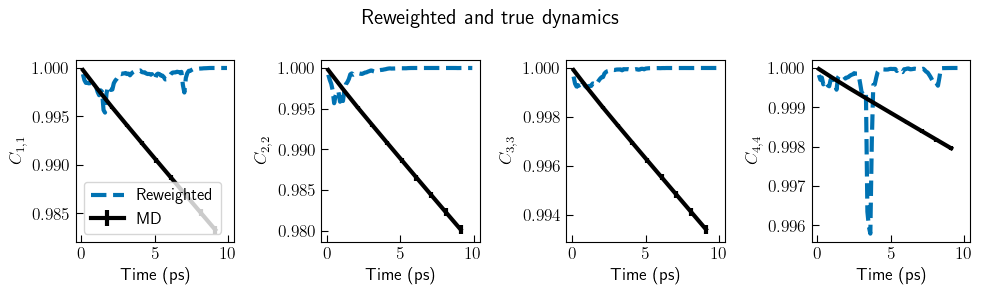

In [206]:
biasedTPM = np.load("model_system/biasedTPMopesFactor5shortsCores.npy")

fig, axs = plt.subplots(1,4,figsize=(10,3))
lag = 10
skip = 10
for i in range(4):

    # The MD dynamics
    axs[i].errorbar(np.arange(1, 101, 1)[::skip] * dt, TPM[1:, i, i][::skip][:10], TPM_error[1:, i, i][::skip][:10], color="black", lw=3)
    axs[i].plot(np.arange(1, 100, 1) * dt, biasedTPM[1:, i, i], lw=3, ls="dashed")

    # 
    axs[i].set_xlabel("Time (ps)")
    index = "{" + f"{i+1},{i+1}" + "}"
    axs[i].set_ylabel(f"$C_{index}$")
axs[0].legend(["Reweighted","MD"])
fig.suptitle("Reweighted and true dynamics")

fig.tight_layout()

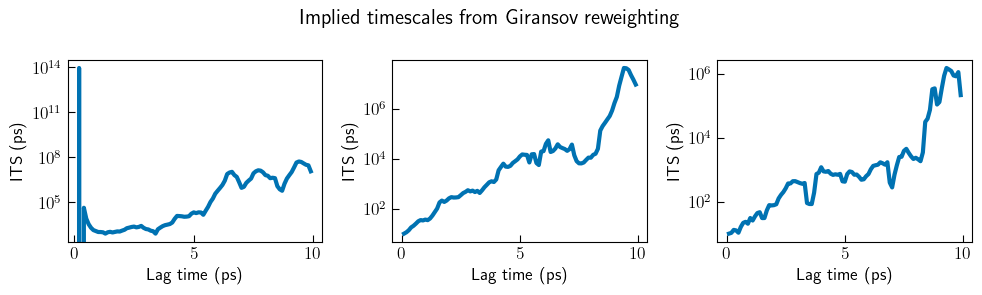

In [209]:
ITS = np.load("model_system/ITSfactor5.npy")
lagtimes = np.linspace(1, 99,99, dtype=int)

fig, axs = plt.subplots(1, 3, figsize = (10, 3))
for i in range(3):
    axs[i].plot(lagtimes * dt, ITS[:,i] * dt, lw=3)
    axs[i].set_xlabel("Lag time (ps)")
    axs[i].set_ylabel("ITS (ps)")
    axs[i].set_yscale("log")
    
fig.suptitle("Implied timescales from Giransov reweighting")
fig.tight_layout()

Nevertheless, the MSM from Girsanov reweighting does suprisingly well, and building U-GMEs from the data works even better! I note that because the data is very noisy, I choose $\tau_r=0$, meaning I average over all times $< \tau_R$. Also note that I use the same lag time for MSMs and U-GMEs, $\tau_R=\tau_L$

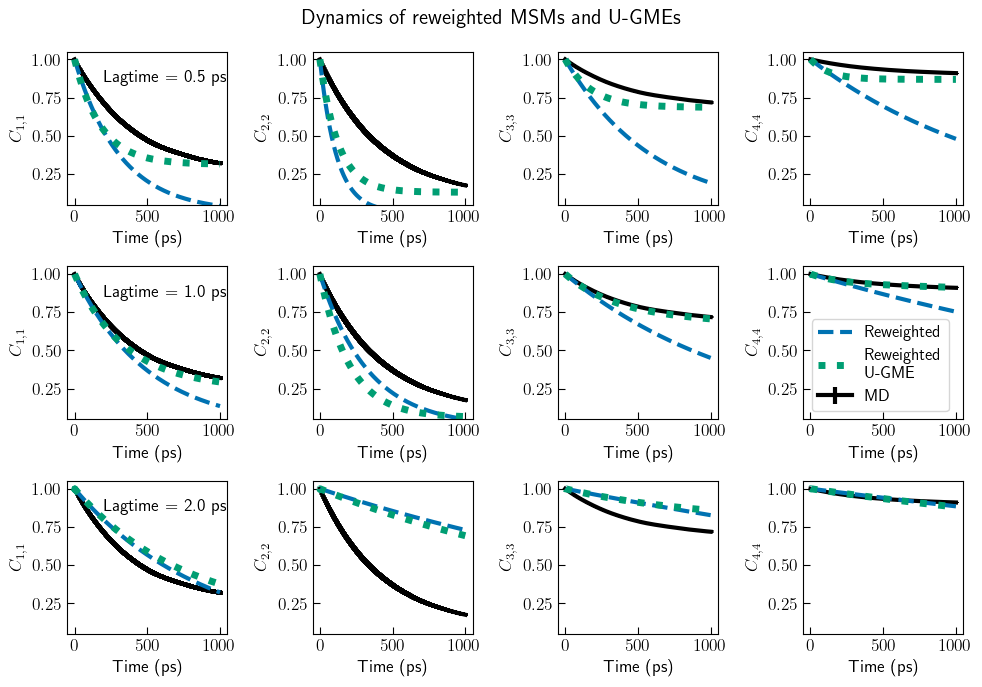

In [211]:
biasedTPM = np.load("model_system/biasedTPMopesFactor5shortsCores.npy")
ugme_data = UGME(dt=dt)
ugme_data.exact = np.einsum("ijk->jki", biasedTPM)
ugme_data.rd = 4
ugme_data.tsteps = 100
U_matrix = ugme_data.Get_U()
fig, axs = plt.subplots(3,4,figsize=(10,7))

lags = [5,10,20]
for j in range(3):
    tau_R = lags[j]
    lag = lags[j]
    t_r = 1
    U_inf = ugme_data.GetAve(t_r = t_r, t_R = tau_R)
    # U_inf = U_matrix[:, :, tau_R]
    # get TPMs with this assumption
    Ct = ugme_data.GetCfromU(U_inf, tau_R, long_tsteps=10000)

    skip = 1
    for i in range(4):

        # The MD dynamics
        axs[j][i].errorbar(np.arange(1, 10001, 1)[::skip] * dt, TPM[1:, i, i][::skip], TPM_error[1:, i, i][::skip], color="black",lw=3,zorder=0)
        # The reweighted MSM dynamics
        axs[j][i].plot(np.arange(lag, 10001, lag) * dt, [biasedTPM[lag, i, i] ** k for k in range(1,int(10000/lag)+1)],lw=3,ls="dashed")
        # # The U_GME dynamics
        axs[j][i].plot(np.arange(1, 10000, 1) * dt, Ct[i, i, :-1], lw = 5, ls = "dotted")


        axs[j][i].set_ylim(0.05,1.05)
        axs[j][i].set_xlabel("Time (ps)")
        index = "{" + f"{i+1},{i+1}" + "}"
        axs[j][i].set_ylabel(f"$C_{index}$")
    axs[j][0].text(200,0.85,f"Lagtime = {lag/10} ps")
axs[1][3].legend(["Reweighted","Reweighted\n U-GME","MD"])
fig.suptitle("Dynamics of reweighted MSMs and U-GMEs")
fig.tight_layout()

The results above were obtained from 10000, 10 ps long simulations and 2000, 100 ps long simulations over a converged OPES bias along the x-axis. No bias was deposited at $-2.5 < x < 2.5$ Angstrom. The target FES $F_U(x)$ is connected to the true FES $F(x)$ through $F_U(x)=0.2F(x)$. I started from randomly selected positions from a Boltzmann distribution over a FES of $0.2F(x,y,z)$. Finally, for the biased simulations, I did not use the partition to macrostates suggested by PCCA+, as it produced strange fake transitions. Instead, I defined the states manually (with the big amount of sampling, the unbiased trajectories give the same dynamics f) to reduce errors from recrossing at the relatively flat transition state, I defined core states that do not span the whole phase space, and left the region $-0.5 < x < 0.5$ Angstrom as not belonging to any state.